In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, recall_score
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
from dataloader_creator import CreatorDL
creator = CreatorDL(seed=42, bs=32)

In [3]:
df_UNSW = creator.reader("NF-UNSW-NB15-v3")

df_train_UNSW, df_test_UNSW, df_val_UNSW = creator.splitter(df_UNSW)

train_loader_UNSW, test_loader_UNSW, val_loader_UNSW = creator.balancer(df_train_UNSW, df_test_UNSW, df_val_UNSW)

Processando a categoria: 'Benign'
  -> Treino: 1118865 | Teste: 559433 | Validação: 559433
Processando a categoria: 'Fuzzers'
  -> Treino: 16908 | Teste: 8454 | Validação: 8454
Processando a categoria: 'Exploits'
  -> Treino: 21374 | Teste: 10687 | Validação: 10687
Processando a categoria: 'Backdoor'
  -> Treino: 2329 | Teste: 1165 | Validação: 1165
Processando a categoria: 'Reconnaissance'
  -> Treino: 8537 | Teste: 4268 | Validação: 4269
Processando a categoria: 'Generic'
  -> Treino: 9825 | Teste: 4913 | Validação: 4913
Processando a categoria: 'DoS'
  -> Treino: 2990 | Teste: 1495 | Validação: 1495
Processando a categoria: 'Shellcode'
  -> Treino: 1190 | Teste: 595 | Validação: 596
Processando a categoria: 'Analysis'
  -> Treino: 613 | Teste: 306 | Validação: 307
Processando a categoria: 'Worms'
  -> Treino: 79 | Teste: 39 | Validação: 40

--- Base de Treino ---
Tamanho: 1182710 linhas
Categorias presentes: ['Benign' 'Exploits' 'Reconnaissance' 'Fuzzers' 'DoS' 'Generic' 'Backdoor'


In [4]:
df_BOT = creator.reader("NF-BoT-IoT-v3")

df_train_BOT, df_test_BOT, df_val_BOT = creator.splitter(df_BOT)

train_loader_BOT, test_loader_BOT, val_loader_BOT = creator.balancer(df_train_BOT, df_test_BOT, df_val_BOT)

Processando a categoria: 'Benign'
  -> Treino: 25994 | Teste: 12997 | Validação: 12998
Processando a categoria: 'DDoS'
  -> Treino: 3575441 | Teste: 1787720 | Validação: 1787721
Processando a categoria: 'DoS'
  -> Treino: 4017095 | Teste: 2008547 | Validação: 2008548
Processando a categoria: 'Reconnaissance'
  -> Treino: 847566 | Teste: 423783 | Validação: 423783
Processando a categoria: 'Theft'
  -> Treino: 807 | Teste: 404 | Validação: 404

--- Base de Treino ---
Tamanho: 8466903 linhas
Categorias presentes: ['DDoS' 'DoS' 'Reconnaissance' 'Benign' 'Theft']
Attack
DoS               4017095
DDoS              3575441
Reconnaissance     847566
Benign              25994
Theft                 807
Name: count, dtype: int64
-------------------------

--- Base de Teste ---
Tamanho: 4233451 linhas
Categorias presentes: ['DDoS' 'DoS' 'Reconnaissance' 'Benign' 'Theft']
Attack
DoS               2008547
DDoS              1787720
Reconnaissance     423783
Benign              12997
Theft            

In [5]:
df_CIC = creator.reader("NF-CICIDS2018-v3")

df_train_CIC, df_test_CIC, df_val_CIC = creator.splitter(df_CIC)

train_loader_CIC, test_loader_CIC, val_loader_CIC = creator.balancer(df_train_CIC, df_test_CIC, df_val_CIC)

Processando a categoria: 'Benign'
  -> Treino: 8757313 | Teste: 4378656 | Validação: 4378657
Processando a categoria: 'FTP-BruteForce'
  -> Treino: 193360 | Teste: 96680 | Validação: 96680
Processando a categoria: 'SSH-Bruteforce'
  -> Treino: 94237 | Teste: 47118 | Validação: 47119
Processando a categoria: 'DoS_attacks-GoldenEye'
  -> Treino: 30650 | Teste: 15325 | Validação: 15325
Processando a categoria: 'DoS_attacks-Slowloris'
  -> Treino: 18020 | Teste: 9010 | Validação: 9010
Processando a categoria: 'DoS_attacks-SlowHTTPTest'
  -> Treino: 52775 | Teste: 26387 | Validação: 26388
Processando a categoria: 'DoS_attacks-Hulk'
  -> Treino: 50038 | Teste: 25019 | Validação: 25019
Processando a categoria: 'DDoS_attacks-LOIC-HTTP'
  -> Treino: 144294 | Teste: 72147 | Validação: 72148
Processando a categoria: 'DDOS_attack-LOIC-UDP'
  -> Treino: 1725 | Teste: 862 | Validação: 863
Processando a categoria: 'DDOS_attack-HOIC'
  -> Treino: 516155 | Teste: 258078 | Validação: 258078
Processando 

In [6]:
model_names = ['UNSW_EA', 'BOT_EA', 'CIC_EA']
test_ids = [1, 2, 3]
train_loaders = [train_loader_UNSW, train_loader_BOT, train_loader_CIC]
test_loaders = [test_loader_UNSW, test_loader_BOT, test_loader_CIC]
val_loaders = [val_loader_UNSW, val_loader_BOT, val_loader_CIC]

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [8]:
INPUT_DIM = 32

class IDSBranchyNet(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, num_classes=2):
        super(IDSBranchyNet, self).__init__()
        
        self.shared_layers = nn.Sequential(
            nn.Linear(input_dim, input_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(input_dim * 2, input_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.2),
        )
        
        self.exit1_layers = nn.Sequential(
            nn.Linear(input_dim * 2, num_classes)
        )
        
        self.exit2_layers = nn.Sequential(
            nn.Linear(input_dim * 2, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, num_classes)
        )

    def forward_exit1(self, x):
        features = self.shared_layers(x)
        return self.exit1_layers(features)

    def forward_exit2(self, x):
        features = self.shared_layers(x)
        return self.exit2_layers(features)

model = IDSBranchyNet()

In [9]:
def train_model(model, train_loader, val_loader, epochs, weight1, weight2, lr, device, patience=15):
    model.to(device)
    criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.001, patience=7)

    train_loss_history = []
    val_loss_history = []

    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs1 = model.forward_exit1(inputs)
            loss1 = criterion(outputs1, labels)
            
            outputs2 = model.forward_exit2(inputs)
            loss2 = criterion(outputs2, labels)
                
            total_loss = (weight1 * loss1) + (weight2 * loss2)

            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_train_loss += total_loss.item()
        
        epoch_train_loss = running_train_loss / len(train_loader)
        train_loss_history.append(epoch_train_loss)

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs1 = model.forward_exit1(inputs)
                loss1 = criterion(outputs1, labels)
                
                outputs2 = model.forward_exit2(inputs)
                loss2 = criterion(outputs2, labels)
                    
                total_loss = (weight1 * loss1) + (weight2 * loss2)
                
                val_loss += total_loss.item()
        
        epoch_val_loss = val_loss/len(val_loader)
        val_loss_history.append(epoch_val_loss)

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}')
        
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            print(f'\n--- EARLY STOPPING ATIVADO ---')
            print(f'Parando o treino na época {epoch+1} pois a loss de validação não melhora há {patience} épocas.')
            print(f'A melhor loss de validação foi: {best_val_loss:.4f}')
            if best_model_state:
                model.load_state_dict(best_model_state)
            break
            
        scheduler.step(epoch_val_loss) 

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label='Loss de Treinamento')
    plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, label='Loss de Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.title('Curvas de Loss de Treinamento e Validação')
    plt.legend()
    plt.grid(True)
    plt.show()

    return train_loss_history, val_loss_history

In [10]:
def evaluate_model(model, loader, confidence_threshold, device):
    model.to(device)
    model.eval()

    total_samples = len(loader.dataset)
    all_predictions = []
    all_labels = []
    exited_early_count = 0
    
    if device.type == 'cuda':
        torch.cuda.synchronize()
        
    start_time = time.perf_counter()

    with torch.no_grad():
        for samples, labels in loader:
            samples, labels = samples.to(device), labels.to(device)

            branch_output = model.forward_exit1(samples)
            
            branch_prob = F.softmax(branch_output, dim=1)
            branch_conf, branch_preds = torch.max(branch_prob, 1)

            batch_predictions = torch.zeros_like(labels)
            
            early_exit_mask = branch_conf > confidence_threshold
            
            if early_exit_mask.any():
                batch_predictions[early_exit_mask] = branch_preds[early_exit_mask]
                exited_early_count += early_exit_mask.sum().item()

            main_branch_mask = ~early_exit_mask
            if main_branch_mask.any():
                
                samples_to_main = samples[main_branch_mask]
                
                main_output = model.forward_exit2(samples_to_main)
                
                main_prob = F.softmax(main_output, dim=1)
                _, main_preds = torch.max(main_prob, 1)
                
                batch_predictions[main_branch_mask] = main_preds

            all_predictions.append(batch_predictions.cpu())
            all_labels.append(labels.cpu())

    if device.type == 'cuda':
        torch.cuda.synchronize()
        
    end_time = time.perf_counter()
    
    total_inference_time = end_time - start_time

    final_predictions = torch.cat(all_predictions)
    y_data = torch.cat(all_labels)

    correct = (final_predictions == y_data).sum().item()
    accuracy = correct / total_samples
    exit_rate = exited_early_count / total_samples
    
    avg_time_ms = (total_inference_time / total_samples) * 1000

    cm = confusion_matrix(y_data.numpy(), final_predictions.numpy())

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Ataque'],
                yticklabels=['Normal', 'Ataque'])
    plt.xlabel('Rótulo Previsto')
    plt.ylabel('Rótulo Verdadeiro')
    plt.title(f'Matriz de Confusão (Limiar de Confiança = {confidence_threshold})')
    plt.show()

    tn, fp, fn, tp = cm.ravel()
    
    f1 = f1_score(y_data.numpy(), final_predictions.numpy())
    
    tpr = recall_score(y_data.numpy(), final_predictions.numpy())

    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    print(f"True Positives (TP): {tp}")
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}\n")
    
    print(f"F1 Score: {f1:.4f}")
    print(f"True Positive Rate (TPR) / Recall: {tpr:.4f}")
    print(f"True Negative Rate (TNR) / Specificity: {tnr:.4f}")

    return {
            'accuracy': accuracy,
            'exit_rate': exit_rate,
            'avg_inference_time_ms': avg_time_ms,
            'exited_early_count': exited_early_count,
            'total_samples': total_samples,
            'total_inference_time_sec': total_inference_time
        }

In [18]:
# epochs = 500

# model_id = 1

# for test in test_ids:
#     model = IDSBranchyNet()
    
#     if test == 1:
#         weight1 = 1
#         weight2 = 0
#     elif test == 2:
#         weight1 = 0
#         weight2 = 1
#     elif test == 3:
#         weight1 = 1
#         weight2 = 1
    
        
#     print(f"--- Training model: {model_names[model_id]} - Weight Exit 1: {weight1}; Weight Exit 2: {weight2}")
    
#     train_losses, val_losses = train_model(model, train_loaders[model_id], val_loaders[model_id], epochs, weight1, weight2, lr=0.0001, device=device, modelname=model_names[model_id])

#     torch.save(model.state_dict(), f'models/{model_names[model_id]}_{test}_v3.pth')
#     print(f"Model saved at 'models/{model_names[model_id]}_{test}_v3.pth'\n")
    

In [ ]:
# epochs = 500

# weight1 = 0
# weight2 = 1

# test = 2

# for model_id in range(len(model_names)):
#     model = IDSBranchyNet()
    
        
#     print(f"--- Training model: {model_names[model_id]} - Weight Exit 1: {weight1}; Weight Exit 2: {weight2}")
    
#     train_losses, val_losses = train_model(model, train_loaders[model_id], val_loaders[model_id], epochs, weight1, weight2, lr=0.0001, device=device)

#     torch.save(model.state_dict(), f'models/{model_names[model_id]}_{test}.pth')
#     print(f"Model saved at 'models/{model_names[model_id]}_{test}.pth'\n")
    

--- Training model: UNSW_EA - Weight Exit 1: 1; Weight Exit 2: 0
Epoch [1/500], Train Loss: 0.6612, Validation Loss: 0.6228
Epoch [2/500], Train Loss: 0.5932, Validation Loss: 0.5727
Epoch [3/500], Train Loss: 0.5414, Validation Loss: 0.5084
Epoch [4/500], Train Loss: 0.4836, Validation Loss: 0.4466
Epoch [5/500], Train Loss: 0.4329, Validation Loss: 0.3919
Epoch [6/500], Train Loss: 0.3868, Validation Loss: 0.3505
Epoch [7/500], Train Loss: 0.3536, Validation Loss: 0.3191
Epoch [8/500], Train Loss: 0.3270, Validation Loss: 0.2932
Epoch [9/500], Train Loss: 0.3007, Validation Loss: 0.2729
Epoch [10/500], Train Loss: 0.2861, Validation Loss: 0.2570
Epoch [11/500], Train Loss: 0.2697, Validation Loss: 0.2439
Epoch [12/500], Train Loss: 0.2523, Validation Loss: 0.2305
Epoch [13/500], Train Loss: 0.2414, Validation Loss: 0.2200
Epoch [14/500], Train Loss: 0.2300, Validation Loss: 0.2123
Epoch [15/500], Train Loss: 0.2200, Validation Loss: 0.2048
Epoch [16/500], Train Loss: 0.2103, Validati

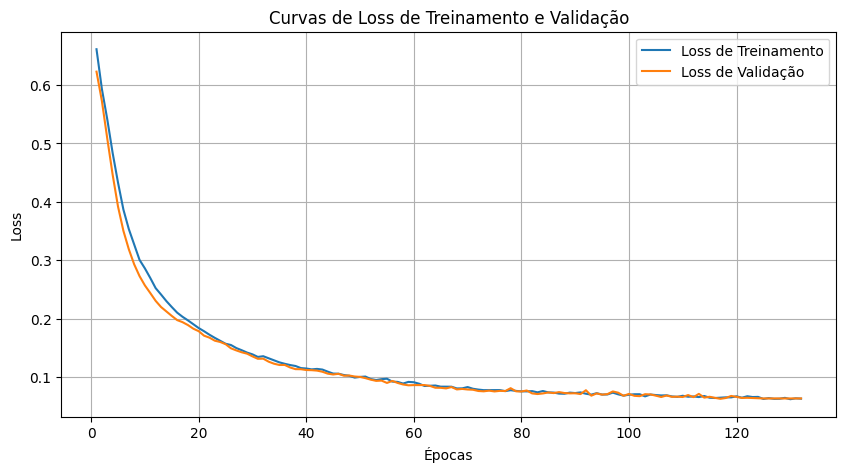

Model saved at 'models/UNSW_EA_1.pth'

--- Training model: UNSW_EA - Weight Exit 1: 0; Weight Exit 2: 1
Epoch [1/500], Train Loss: 0.5990, Validation Loss: 0.5225
Epoch [2/500], Train Loss: 0.5057, Validation Loss: 0.4003
Epoch [3/500], Train Loss: 0.4404, Validation Loss: 0.3346
Epoch [4/500], Train Loss: 0.3762, Validation Loss: 0.2664
Epoch [5/500], Train Loss: 0.3265, Validation Loss: 0.2313
Epoch [6/500], Train Loss: 0.2898, Validation Loss: 0.2523
Epoch [7/500], Train Loss: 0.2669, Validation Loss: 0.2331
Epoch [8/500], Train Loss: 0.2425, Validation Loss: 0.1951
Epoch [9/500], Train Loss: 0.2279, Validation Loss: 0.1895
Epoch [10/500], Train Loss: 0.2139, Validation Loss: 0.1712
Epoch [11/500], Train Loss: 0.1982, Validation Loss: 0.1601
Epoch [12/500], Train Loss: 0.1912, Validation Loss: 0.1569
Epoch [13/500], Train Loss: 0.1782, Validation Loss: 0.1465
Epoch [14/500], Train Loss: 0.1688, Validation Loss: 0.1468
Epoch [15/500], Train Loss: 0.1660, Validation Loss: 0.1333
Epoch

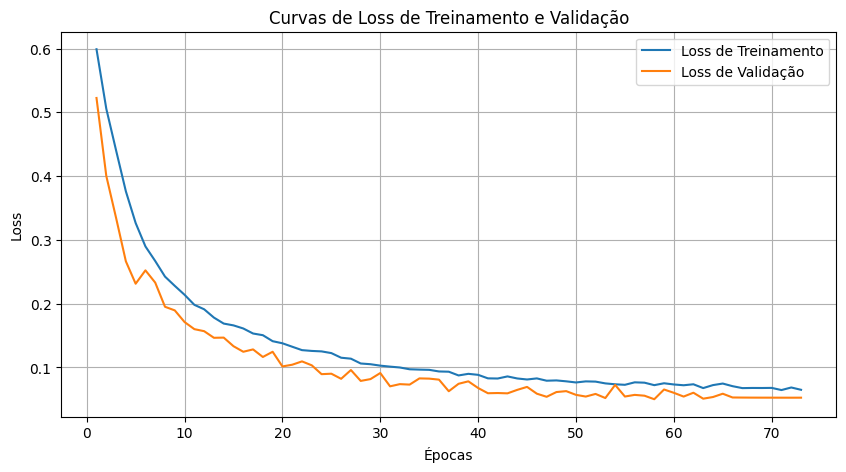

Model saved at 'models/UNSW_EA_2.pth'

--- Training model: UNSW_EA - Weight Exit 1: 1; Weight Exit 2: 1
Epoch [1/500], Train Loss: 1.3007, Validation Loss: 1.1991
Epoch [2/500], Train Loss: 1.1812, Validation Loss: 1.0510
Epoch [3/500], Train Loss: 1.0619, Validation Loss: 0.9635
Epoch [4/500], Train Loss: 0.9674, Validation Loss: 0.8464
Epoch [5/500], Train Loss: 0.8823, Validation Loss: 0.8116
Epoch [6/500], Train Loss: 0.8070, Validation Loss: 0.7092
Epoch [7/500], Train Loss: 0.7400, Validation Loss: 0.6570
Epoch [8/500], Train Loss: 0.6780, Validation Loss: 0.6216
Epoch [9/500], Train Loss: 0.6234, Validation Loss: 0.5707
Epoch [10/500], Train Loss: 0.5838, Validation Loss: 0.5310
Epoch [11/500], Train Loss: 0.5412, Validation Loss: 0.4859
Epoch [12/500], Train Loss: 0.5048, Validation Loss: 0.4594
Epoch [13/500], Train Loss: 0.4720, Validation Loss: 0.4283
Epoch [14/500], Train Loss: 0.4431, Validation Loss: 0.4229
Epoch [15/500], Train Loss: 0.4244, Validation Loss: 0.3889
Epoch

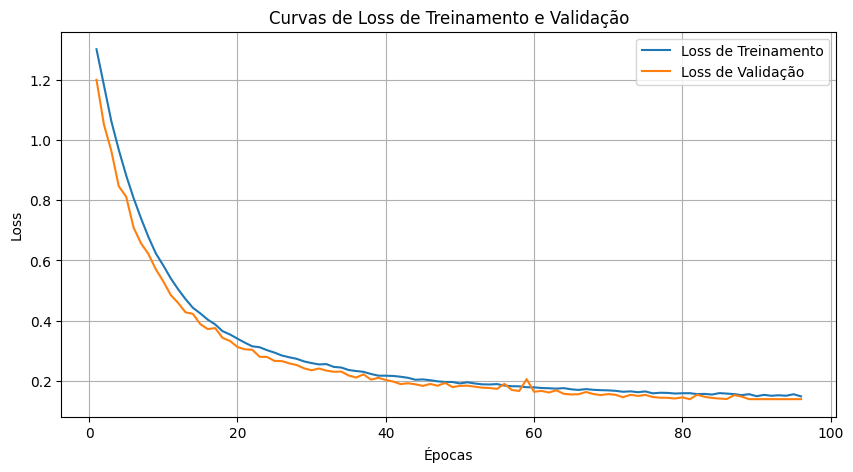

Model saved at 'models/UNSW_EA_3.pth'

--- Training model: BOT_EA - Weight Exit 1: 1; Weight Exit 2: 0
Epoch [1/500], Train Loss: 0.6879, Validation Loss: 0.6807
Epoch [2/500], Train Loss: 0.6665, Validation Loss: 0.6419
Epoch [3/500], Train Loss: 0.6127, Validation Loss: 0.5764
Epoch [4/500], Train Loss: 0.5569, Validation Loss: 0.5329
Epoch [5/500], Train Loss: 0.5276, Validation Loss: 0.5091
Epoch [6/500], Train Loss: 0.5104, Validation Loss: 0.4927
Epoch [7/500], Train Loss: 0.4953, Validation Loss: 0.4782
Epoch [8/500], Train Loss: 0.4827, Validation Loss: 0.4662
Epoch [9/500], Train Loss: 0.4734, Validation Loss: 0.4565
Epoch [10/500], Train Loss: 0.4660, Validation Loss: 0.4481
Epoch [11/500], Train Loss: 0.4581, Validation Loss: 0.4410
Epoch [12/500], Train Loss: 0.4498, Validation Loss: 0.4350
Epoch [13/500], Train Loss: 0.4467, Validation Loss: 0.4304
Epoch [14/500], Train Loss: 0.4434, Validation Loss: 0.4259
Epoch [15/500], Train Loss: 0.4379, Validation Loss: 0.4225
Epoch 

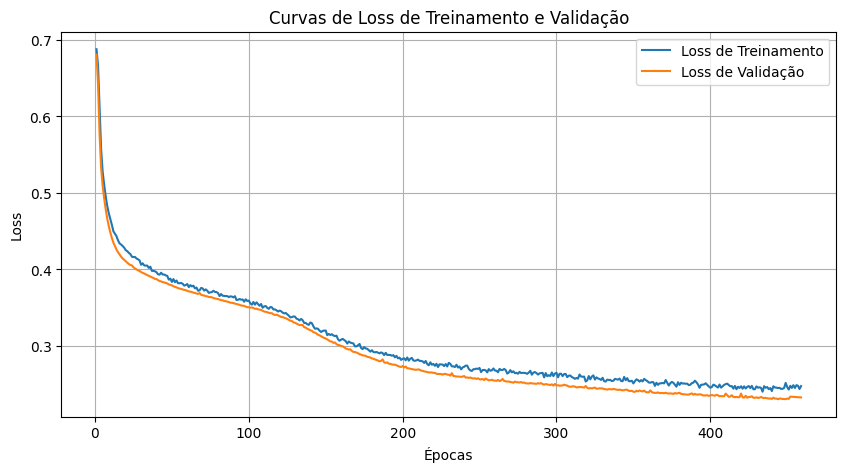

Model saved at 'models/BOT_EA_1.pth'

--- Training model: BOT_EA - Weight Exit 1: 0; Weight Exit 2: 1
Epoch [1/500], Train Loss: 0.6439, Validation Loss: 0.5251
Epoch [2/500], Train Loss: 0.5389, Validation Loss: 0.4861
Epoch [3/500], Train Loss: 0.5018, Validation Loss: 0.4657
Epoch [4/500], Train Loss: 0.4795, Validation Loss: 0.4527
Epoch [5/500], Train Loss: 0.4758, Validation Loss: 0.4533
Epoch [6/500], Train Loss: 0.4602, Validation Loss: 0.4290
Epoch [7/500], Train Loss: 0.4548, Validation Loss: 0.4217
Epoch [8/500], Train Loss: 0.4501, Validation Loss: 0.4195
Epoch [9/500], Train Loss: 0.4378, Validation Loss: 0.4214
Epoch [10/500], Train Loss: 0.4369, Validation Loss: 0.4114
Epoch [11/500], Train Loss: 0.4350, Validation Loss: 0.4130
Epoch [12/500], Train Loss: 0.4307, Validation Loss: 0.4045
Epoch [13/500], Train Loss: 0.4265, Validation Loss: 0.4030
Epoch [14/500], Train Loss: 0.4252, Validation Loss: 0.4082
Epoch [15/500], Train Loss: 0.4195, Validation Loss: 0.4063
Epoch [

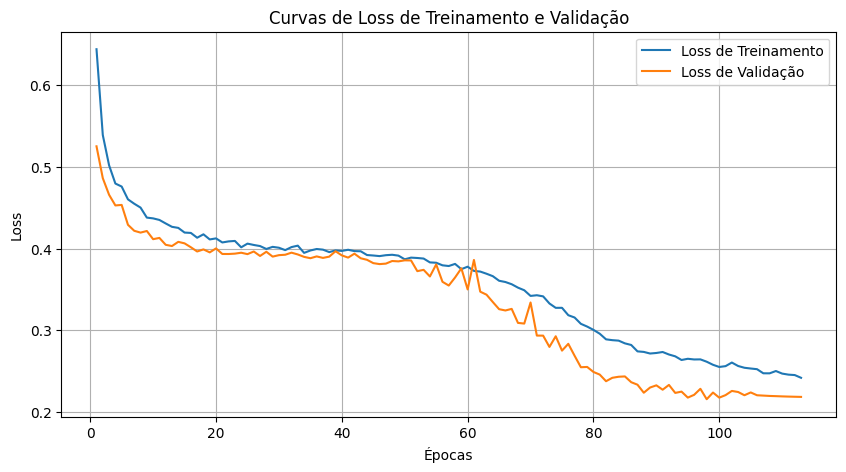

Model saved at 'models/BOT_EA_2.pth'

--- Training model: BOT_EA - Weight Exit 1: 1; Weight Exit 2: 1
Epoch [1/500], Train Loss: 1.3345, Validation Loss: 1.1919
Epoch [2/500], Train Loss: 1.2141, Validation Loss: 1.1550
Epoch [3/500], Train Loss: 1.1686, Validation Loss: 1.1252
Epoch [4/500], Train Loss: 1.1309, Validation Loss: 1.0912
Epoch [5/500], Train Loss: 1.1013, Validation Loss: 1.0538
Epoch [6/500], Train Loss: 1.0589, Validation Loss: 1.0057
Epoch [7/500], Train Loss: 1.0198, Validation Loss: 0.9691
Epoch [8/500], Train Loss: 0.9768, Validation Loss: 0.9448
Epoch [9/500], Train Loss: 0.9562, Validation Loss: 0.9150
Epoch [10/500], Train Loss: 0.9312, Validation Loss: 0.8920
Epoch [11/500], Train Loss: 0.9167, Validation Loss: 0.8792
Epoch [12/500], Train Loss: 0.9047, Validation Loss: 0.8671
Epoch [13/500], Train Loss: 0.8960, Validation Loss: 0.8568
Epoch [14/500], Train Loss: 0.8787, Validation Loss: 0.8497
Epoch [15/500], Train Loss: 0.8678, Validation Loss: 0.8423
Epoch [

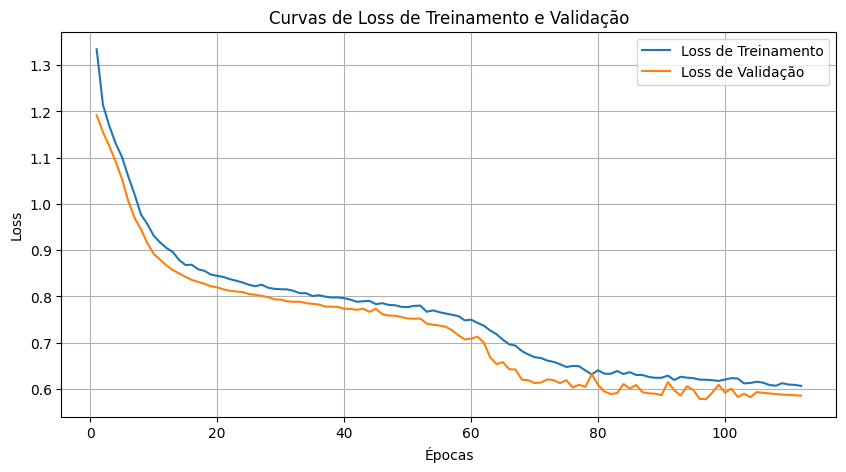

Model saved at 'models/BOT_EA_3.pth'

--- Training model: CIC_EA - Weight Exit 1: 1; Weight Exit 2: 0
Epoch [1/500], Train Loss: 0.6475, Validation Loss: 0.5699
Epoch [2/500], Train Loss: 0.5184, Validation Loss: 0.4757
Epoch [3/500], Train Loss: 0.4641, Validation Loss: 0.4421
Epoch [4/500], Train Loss: 0.4433, Validation Loss: 0.4275
Epoch [5/500], Train Loss: 0.4340, Validation Loss: 0.4191
Epoch [6/500], Train Loss: 0.4239, Validation Loss: 0.4091
Epoch [7/500], Train Loss: 0.4159, Validation Loss: 0.3998
Epoch [8/500], Train Loss: 0.4056, Validation Loss: 0.3899
Epoch [9/500], Train Loss: 0.3962, Validation Loss: 0.3787
Epoch [10/500], Train Loss: 0.3845, Validation Loss: 0.3663
Epoch [11/500], Train Loss: 0.3728, Validation Loss: 0.3536
Epoch [12/500], Train Loss: 0.3594, Validation Loss: 0.3406
Epoch [13/500], Train Loss: 0.3474, Validation Loss: 0.3275
Epoch [14/500], Train Loss: 0.3336, Validation Loss: 0.3125
Epoch [15/500], Train Loss: 0.3207, Validation Loss: 0.2992
Epoch [

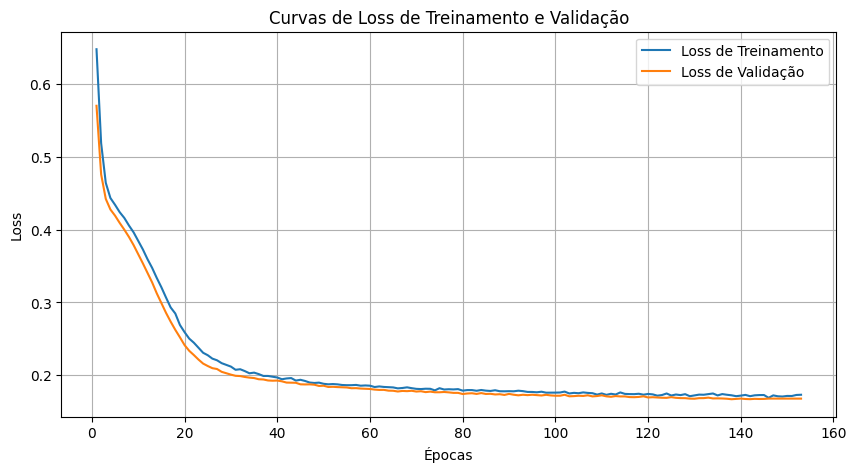

Model saved at 'models/CIC_EA_1.pth'

--- Training model: CIC_EA - Weight Exit 1: 0; Weight Exit 2: 1
Epoch [1/500], Train Loss: 0.5710, Validation Loss: 0.4579
Epoch [2/500], Train Loss: 0.4678, Validation Loss: 0.4148
Epoch [3/500], Train Loss: 0.4310, Validation Loss: 0.4014
Epoch [4/500], Train Loss: 0.4007, Validation Loss: 0.3591
Epoch [5/500], Train Loss: 0.3743, Validation Loss: 0.3327
Epoch [6/500], Train Loss: 0.3559, Validation Loss: 0.3028
Epoch [7/500], Train Loss: 0.3395, Validation Loss: 0.3070
Epoch [8/500], Train Loss: 0.3188, Validation Loss: 0.2489
Epoch [9/500], Train Loss: 0.2996, Validation Loss: 0.2383
Epoch [10/500], Train Loss: 0.2792, Validation Loss: 0.2199
Epoch [11/500], Train Loss: 0.2600, Validation Loss: 0.2150
Epoch [12/500], Train Loss: 0.2515, Validation Loss: 0.2088
Epoch [13/500], Train Loss: 0.2380, Validation Loss: 0.2105
Epoch [14/500], Train Loss: 0.2325, Validation Loss: 0.2054
Epoch [15/500], Train Loss: 0.2285, Validation Loss: 0.2272
Epoch [

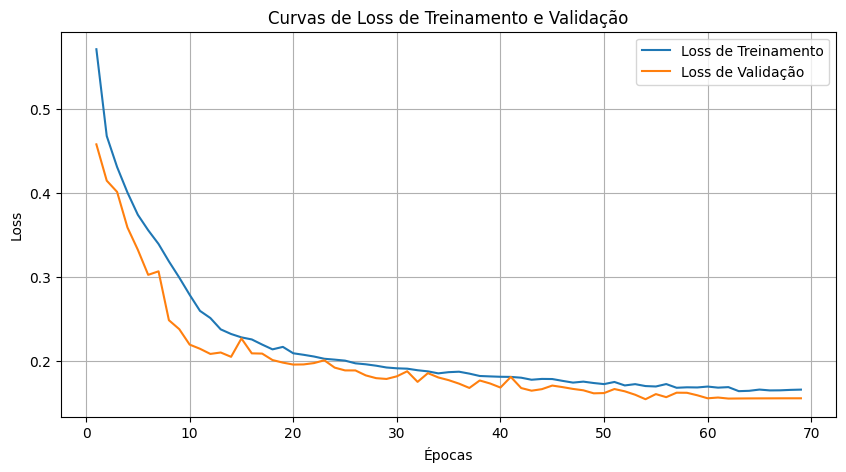

Model saved at 'models/CIC_EA_2.pth'

--- Training model: CIC_EA - Weight Exit 1: 1; Weight Exit 2: 1
Epoch [1/500], Train Loss: 1.2387, Validation Loss: 1.1176
Epoch [2/500], Train Loss: 1.0722, Validation Loss: 0.9675
Epoch [3/500], Train Loss: 0.9577, Validation Loss: 0.8979
Epoch [4/500], Train Loss: 0.8847, Validation Loss: 0.8317
Epoch [5/500], Train Loss: 0.8322, Validation Loss: 0.7876
Epoch [6/500], Train Loss: 0.7853, Validation Loss: 0.7390
Epoch [7/500], Train Loss: 0.7437, Validation Loss: 0.6695
Epoch [8/500], Train Loss: 0.7017, Validation Loss: 0.6246
Epoch [9/500], Train Loss: 0.6664, Validation Loss: 0.5958
Epoch [10/500], Train Loss: 0.6370, Validation Loss: 0.5824
Epoch [11/500], Train Loss: 0.6171, Validation Loss: 0.5627
Epoch [12/500], Train Loss: 0.5916, Validation Loss: 0.5465
Epoch [13/500], Train Loss: 0.5656, Validation Loss: 0.5374
Epoch [14/500], Train Loss: 0.5522, Validation Loss: 0.5246
Epoch [15/500], Train Loss: 0.5337, Validation Loss: 0.5198
Epoch [

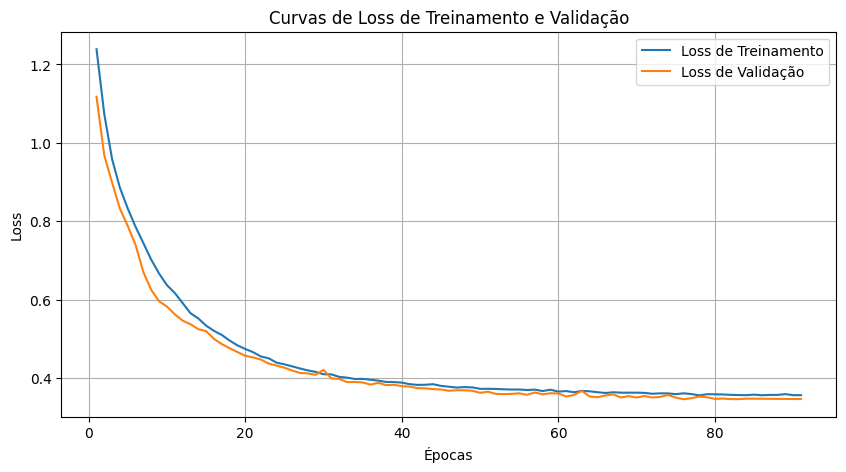

Model saved at 'models/CIC_EA_3.pth'



In [11]:
epochs = 500

for model_id in range(len(model_names)):
    for test in test_ids:
        model = IDSBranchyNet()
        
        if test == 1:
            weight1 = 1
            weight2 = 0
        elif test == 2:
            weight1 = 0
            weight2 = 1
        elif test == 3:
            weight1 = 1
            weight2 = 1
        
            
        print(f"--- Training model: {model_names[model_id]} - Weight Exit 1: {weight1}; Weight Exit 2: {weight2}")
        
        train_losses, val_losses = train_model(model, train_loaders[model_id], val_loaders[model_id], epochs, weight1, weight2, lr=0.0001, device=device)

        torch.save(model.state_dict(), f'models/{model_names[model_id]}_{test}.pth')
        print(f"Model saved at 'models/{model_names[model_id]}_{test}.pth'\n")
        

In [21]:
# for model_id in range(len(model_names)):
#     for loader in range(len(test_loaders)):
#         print(f"--- Model: {model_names[model_id]} | Loader: {model_names[loader]} | TestID: {test} ---")

#         model.load_state_dict(torch.load(f'models/{model_names[model_id]}_2_v2.pth'))
#         model.to(device)
#         model.eval()
#         print(f"Model from: 'models/{model_names[model_id]}_2_v2.pth' carregado")

#         t=2

#         results = evaluate_model(model, test_loaders[loader], confidence_threshold=t, device=device)
        
#         print("-" * 20)
#         print(f"Threshold: {t:.4f}")
#         print(f"  Accuracy: {results['accuracy']:.4f}")
#         print(f"  Total Inference Time: {results['total_inference_time_sec']:.4f} s")
#         print(f"  Early Exit Rate: {results['exit_rate']:.4f} ({results['exited_early_count']}/{results['total_samples']})")
#         print("-" * 20)
#         print("\n")

0.9999
--- Model: UNSW_EA | Loader: UNSW_EA | TestID: 1 ---
Model from: 'models/UNSW_EA_1.pth' carregado


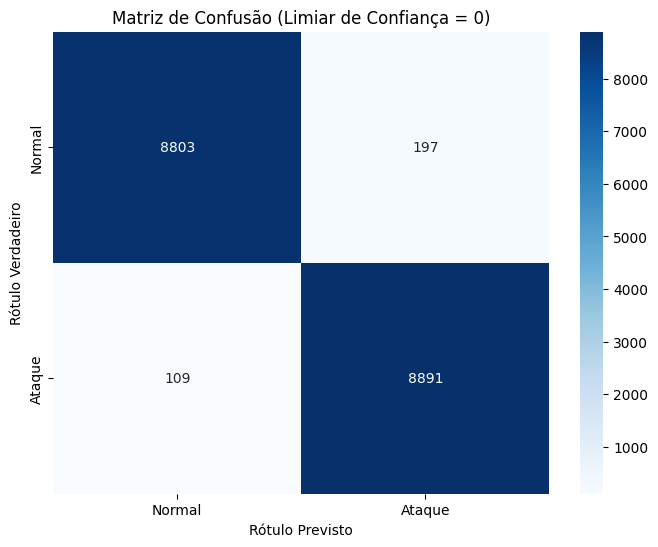

True Positives (TP): 8891
True Negatives (TN): 8803
False Positives (FP): 197
False Negatives (FN): 109

F1 Score: 0.9831
True Positive Rate (TPR) / Recall: 0.9879
True Negative Rate (TNR) / Specificity: 0.9781
--------------------
Threshold: 0.0000
  Accuracy: 0.9830
  Total Inference Time: 0.7447 s
  Early Exit Rate: 1.0000 (18000/18000)
--------------------


--- Model: UNSW_EA | Loader: UNSW_EA | TestID: 2 ---
Model from: 'models/UNSW_EA_2.pth' carregado


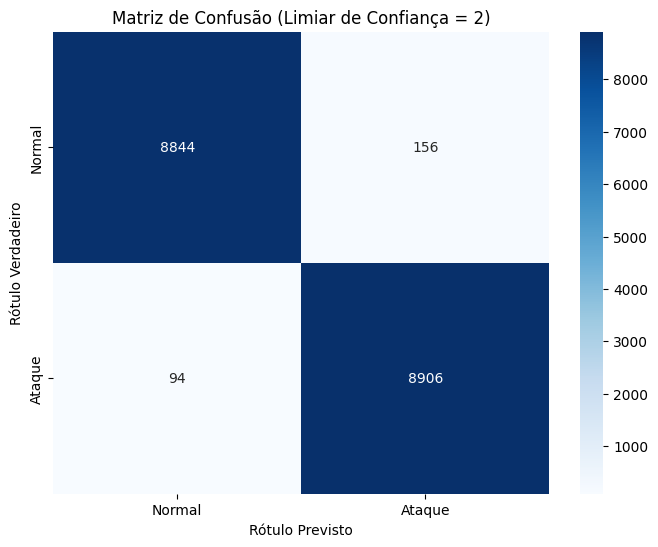

True Positives (TP): 8906
True Negatives (TN): 8844
False Positives (FP): 156
False Negatives (FN): 94

F1 Score: 0.9862
True Positive Rate (TPR) / Recall: 0.9896
True Negative Rate (TNR) / Specificity: 0.9827
--------------------
Threshold: 2.0000
  Accuracy: 0.9861
  Total Inference Time: 0.9597 s
  Early Exit Rate: 0.0000 (0/18000)
--------------------


--- Model: UNSW_EA | Loader: UNSW_EA | TestID: 3 ---
Model from: 'models/UNSW_EA_3.pth' carregado


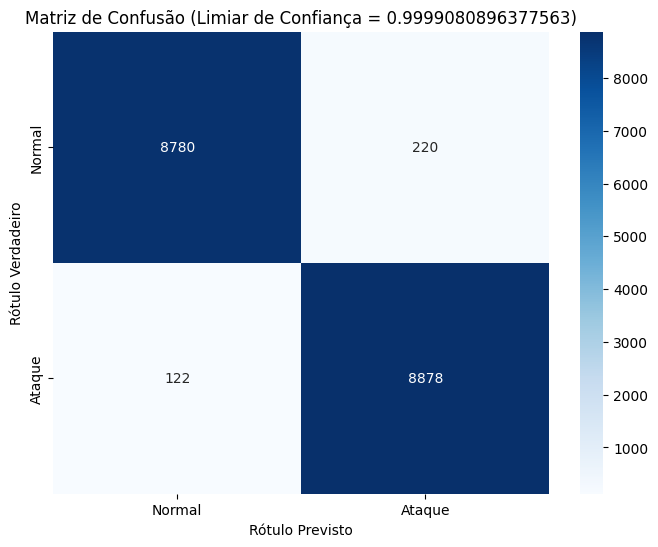

True Positives (TP): 8878
True Negatives (TN): 8780
False Positives (FP): 220
False Negatives (FN): 122

F1 Score: 0.9811
True Positive Rate (TPR) / Recall: 0.9864
True Negative Rate (TNR) / Specificity: 0.9756
--------------------
Threshold: 0.9999
  Accuracy: 0.9810
  Total Inference Time: 1.2812 s
  Early Exit Rate: 0.1929 (3472/18000)
--------------------


--- Model: UNSW_EA | Loader: BOT_EA | TestID: 1 ---
Model from: 'models/UNSW_EA_1.pth' carregado


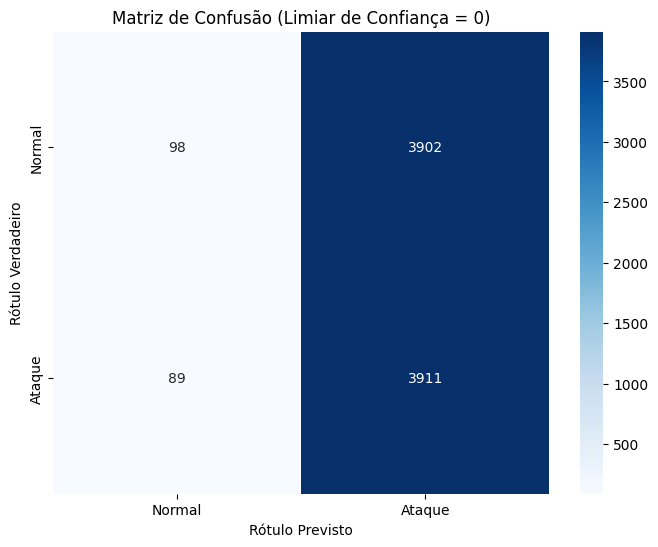

True Positives (TP): 3911
True Negatives (TN): 98
False Positives (FP): 3902
False Negatives (FN): 89

F1 Score: 0.6622
True Positive Rate (TPR) / Recall: 0.9778
True Negative Rate (TNR) / Specificity: 0.0245
--------------------
Threshold: 0.0000
  Accuracy: 0.5011
  Total Inference Time: 0.2861 s
  Early Exit Rate: 1.0000 (8000/8000)
--------------------


--- Model: UNSW_EA | Loader: BOT_EA | TestID: 2 ---
Model from: 'models/UNSW_EA_2.pth' carregado


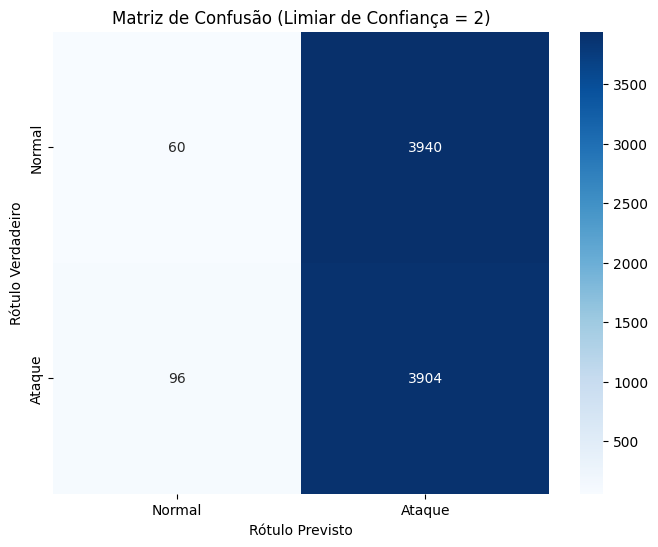

True Positives (TP): 3904
True Negatives (TN): 60
False Positives (FP): 3940
False Negatives (FN): 96

F1 Score: 0.6592
True Positive Rate (TPR) / Recall: 0.9760
True Negative Rate (TNR) / Specificity: 0.0150
--------------------
Threshold: 2.0000
  Accuracy: 0.4955
  Total Inference Time: 0.4205 s
  Early Exit Rate: 0.0000 (0/8000)
--------------------


--- Model: UNSW_EA | Loader: BOT_EA | TestID: 3 ---
Model from: 'models/UNSW_EA_3.pth' carregado


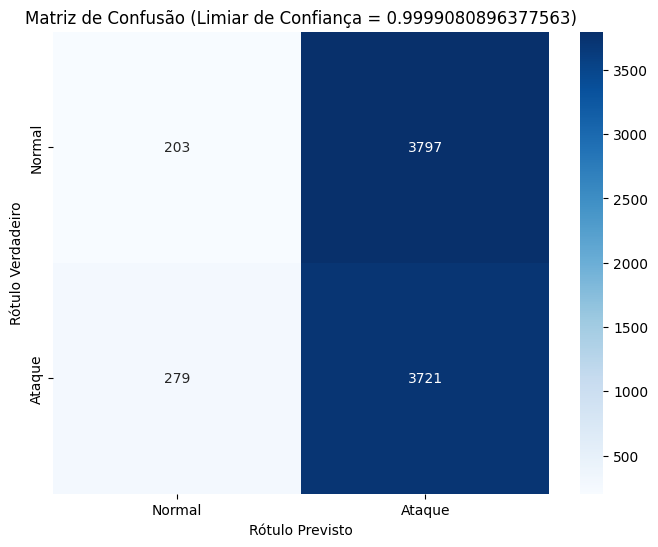

True Positives (TP): 3721
True Negatives (TN): 203
False Positives (FP): 3797
False Negatives (FN): 279

F1 Score: 0.6461
True Positive Rate (TPR) / Recall: 0.9303
True Negative Rate (TNR) / Specificity: 0.0508
--------------------
Threshold: 0.9999
  Accuracy: 0.4905
  Total Inference Time: 0.4939 s
  Early Exit Rate: 0.0862 (690/8000)
--------------------


--- Model: UNSW_EA | Loader: CIC_EA | TestID: 1 ---
Model from: 'models/UNSW_EA_1.pth' carregado


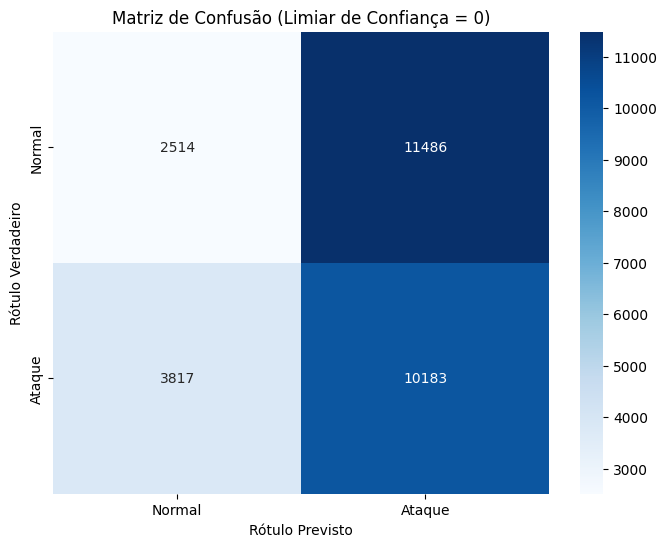

True Positives (TP): 10183
True Negatives (TN): 2514
False Positives (FP): 11486
False Negatives (FN): 3817

F1 Score: 0.5710
True Positive Rate (TPR) / Recall: 0.7274
True Negative Rate (TNR) / Specificity: 0.1796
--------------------
Threshold: 0.0000
  Accuracy: 0.4535
  Total Inference Time: 1.0896 s
  Early Exit Rate: 1.0000 (28000/28000)
--------------------


--- Model: UNSW_EA | Loader: CIC_EA | TestID: 2 ---
Model from: 'models/UNSW_EA_2.pth' carregado


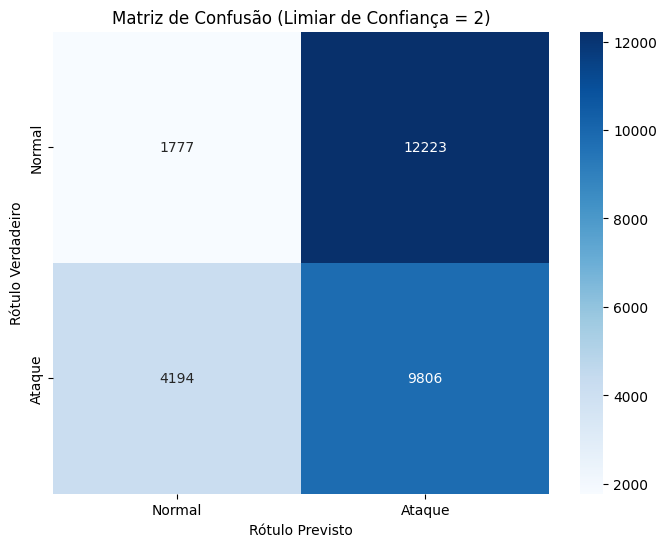

True Positives (TP): 9806
True Negatives (TN): 1777
False Positives (FP): 12223
False Negatives (FN): 4194

F1 Score: 0.5443
True Positive Rate (TPR) / Recall: 0.7004
True Negative Rate (TNR) / Specificity: 0.1269
--------------------
Threshold: 2.0000
  Accuracy: 0.4137
  Total Inference Time: 1.5472 s
  Early Exit Rate: 0.0000 (0/28000)
--------------------


--- Model: UNSW_EA | Loader: CIC_EA | TestID: 3 ---
Model from: 'models/UNSW_EA_3.pth' carregado


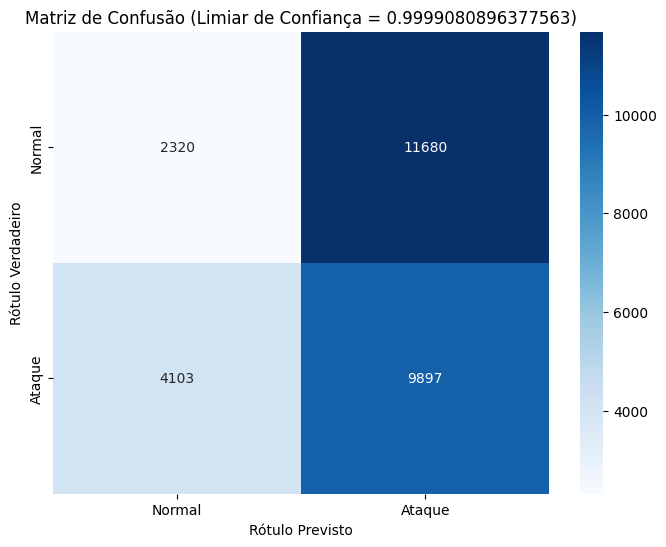

True Positives (TP): 9897
True Negatives (TN): 2320
False Positives (FP): 11680
False Negatives (FN): 4103

F1 Score: 0.5564
True Positive Rate (TPR) / Recall: 0.7069
True Negative Rate (TNR) / Specificity: 0.1657
--------------------
Threshold: 0.9999
  Accuracy: 0.4363
  Total Inference Time: 1.6971 s
  Early Exit Rate: 0.1250 (3501/28000)
--------------------


--- Model: BOT_EA | Loader: UNSW_EA | TestID: 1 ---
Model from: 'models/BOT_EA_1.pth' carregado


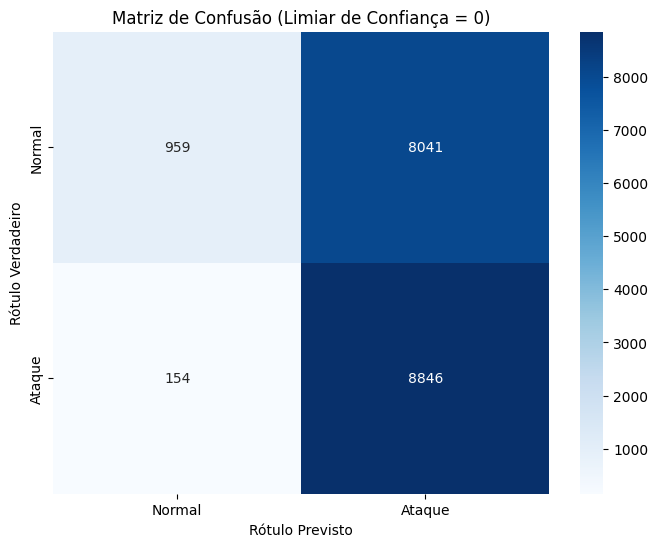

True Positives (TP): 8846
True Negatives (TN): 959
False Positives (FP): 8041
False Negatives (FN): 154

F1 Score: 0.6834
True Positive Rate (TPR) / Recall: 0.9829
True Negative Rate (TNR) / Specificity: 0.1066
--------------------
Threshold: 0.0000
  Accuracy: 0.5447
  Total Inference Time: 0.6710 s
  Early Exit Rate: 1.0000 (18000/18000)
--------------------


--- Model: BOT_EA | Loader: UNSW_EA | TestID: 2 ---
Model from: 'models/BOT_EA_2.pth' carregado


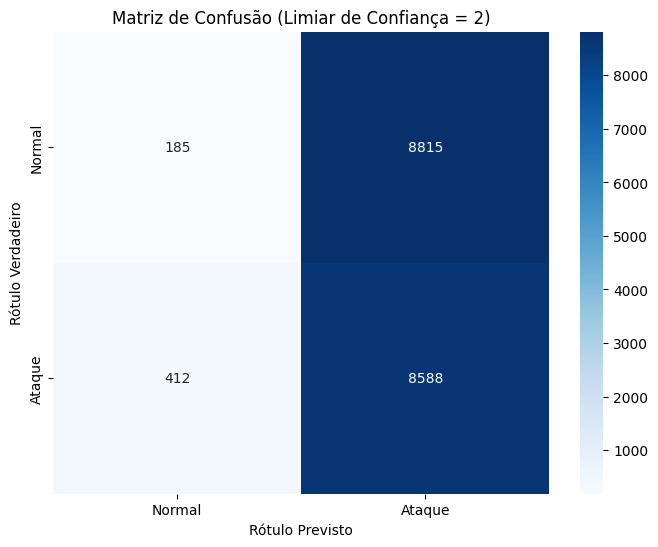

True Positives (TP): 8588
True Negatives (TN): 185
False Positives (FP): 8815
False Negatives (FN): 412

F1 Score: 0.6505
True Positive Rate (TPR) / Recall: 0.9542
True Negative Rate (TNR) / Specificity: 0.0206
--------------------
Threshold: 2.0000
  Accuracy: 0.4874
  Total Inference Time: 0.9633 s
  Early Exit Rate: 0.0000 (0/18000)
--------------------


--- Model: BOT_EA | Loader: UNSW_EA | TestID: 3 ---
Model from: 'models/BOT_EA_3.pth' carregado


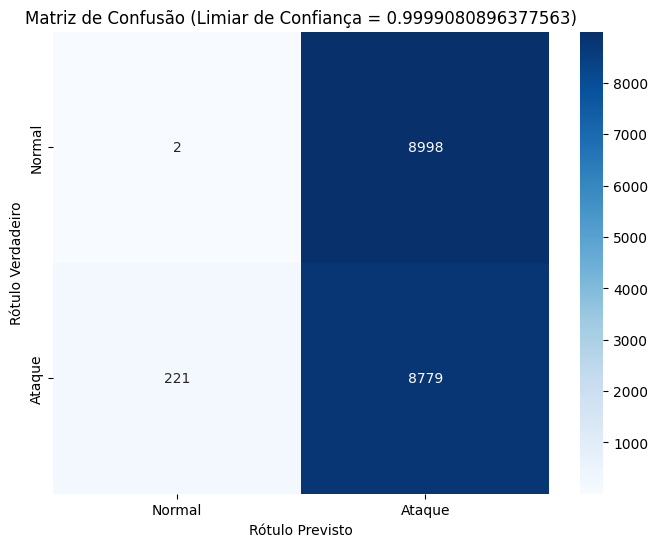

True Positives (TP): 8779
True Negatives (TN): 2
False Positives (FP): 8998
False Negatives (FN): 221

F1 Score: 0.6557
True Positive Rate (TPR) / Recall: 0.9754
True Negative Rate (TNR) / Specificity: 0.0002
--------------------
Threshold: 0.9999
  Accuracy: 0.4878
  Total Inference Time: 1.2131 s
  Early Exit Rate: 0.5066 (9118/18000)
--------------------


--- Model: BOT_EA | Loader: BOT_EA | TestID: 1 ---
Model from: 'models/BOT_EA_1.pth' carregado


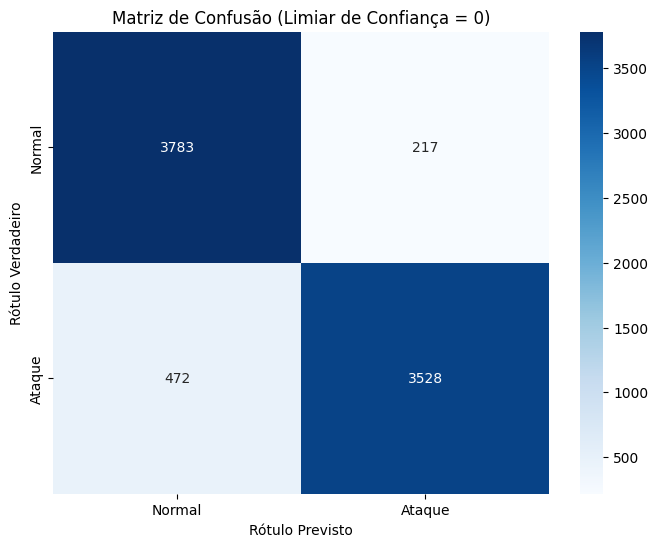

True Positives (TP): 3528
True Negatives (TN): 3783
False Positives (FP): 217
False Negatives (FN): 472

F1 Score: 0.9110
True Positive Rate (TPR) / Recall: 0.8820
True Negative Rate (TNR) / Specificity: 0.9457
--------------------
Threshold: 0.0000
  Accuracy: 0.9139
  Total Inference Time: 0.3248 s
  Early Exit Rate: 1.0000 (8000/8000)
--------------------


--- Model: BOT_EA | Loader: BOT_EA | TestID: 2 ---
Model from: 'models/BOT_EA_2.pth' carregado


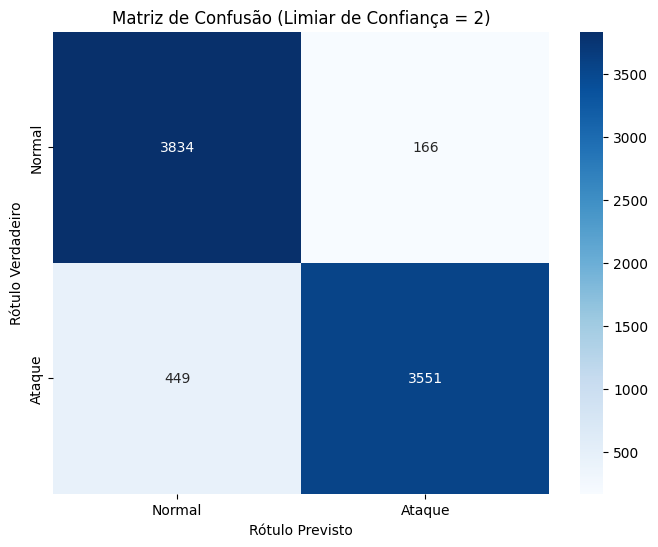

True Positives (TP): 3551
True Negatives (TN): 3834
False Positives (FP): 166
False Negatives (FN): 449

F1 Score: 0.9203
True Positive Rate (TPR) / Recall: 0.8878
True Negative Rate (TNR) / Specificity: 0.9585
--------------------
Threshold: 2.0000
  Accuracy: 0.9231
  Total Inference Time: 0.4628 s
  Early Exit Rate: 0.0000 (0/8000)
--------------------


--- Model: BOT_EA | Loader: BOT_EA | TestID: 3 ---
Model from: 'models/BOT_EA_3.pth' carregado


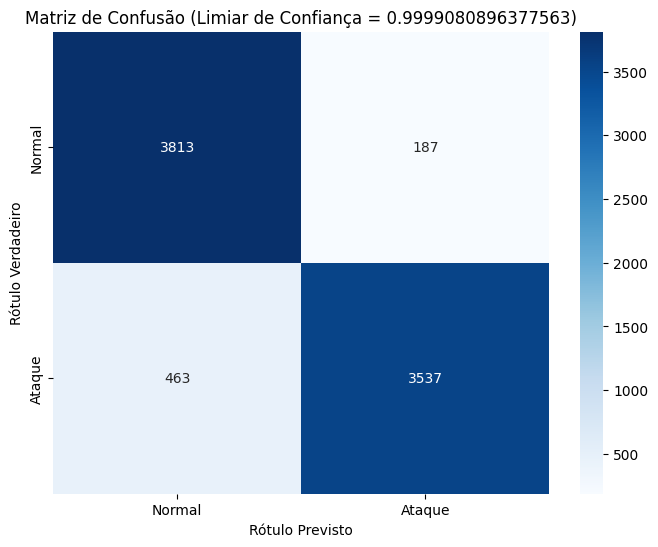

True Positives (TP): 3537
True Negatives (TN): 3813
False Positives (FP): 187
False Negatives (FN): 463

F1 Score: 0.9158
True Positive Rate (TPR) / Recall: 0.8842
True Negative Rate (TNR) / Specificity: 0.9533
--------------------
Threshold: 0.9999
  Accuracy: 0.9187
  Total Inference Time: 0.4681 s
  Early Exit Rate: 0.0912 (730/8000)
--------------------


--- Model: BOT_EA | Loader: CIC_EA | TestID: 1 ---
Model from: 'models/BOT_EA_1.pth' carregado


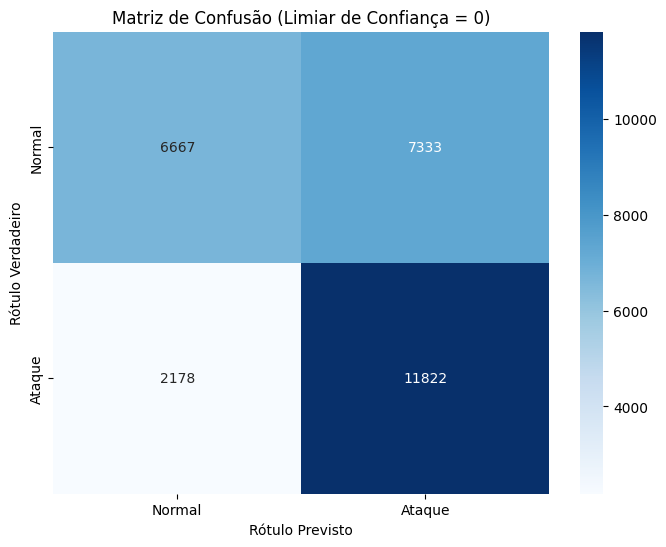

True Positives (TP): 11822
True Negatives (TN): 6667
False Positives (FP): 7333
False Negatives (FN): 2178

F1 Score: 0.7131
True Positive Rate (TPR) / Recall: 0.8444
True Negative Rate (TNR) / Specificity: 0.4762
--------------------
Threshold: 0.0000
  Accuracy: 0.6603
  Total Inference Time: 1.0288 s
  Early Exit Rate: 1.0000 (28000/28000)
--------------------


--- Model: BOT_EA | Loader: CIC_EA | TestID: 2 ---
Model from: 'models/BOT_EA_2.pth' carregado


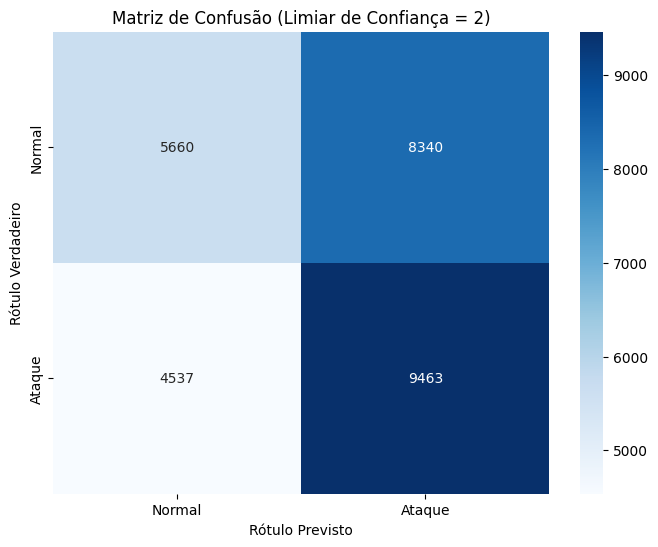

True Positives (TP): 9463
True Negatives (TN): 5660
False Positives (FP): 8340
False Negatives (FN): 4537

F1 Score: 0.5951
True Positive Rate (TPR) / Recall: 0.6759
True Negative Rate (TNR) / Specificity: 0.4043
--------------------
Threshold: 2.0000
  Accuracy: 0.5401
  Total Inference Time: 1.4788 s
  Early Exit Rate: 0.0000 (0/28000)
--------------------


--- Model: BOT_EA | Loader: CIC_EA | TestID: 3 ---
Model from: 'models/BOT_EA_3.pth' carregado


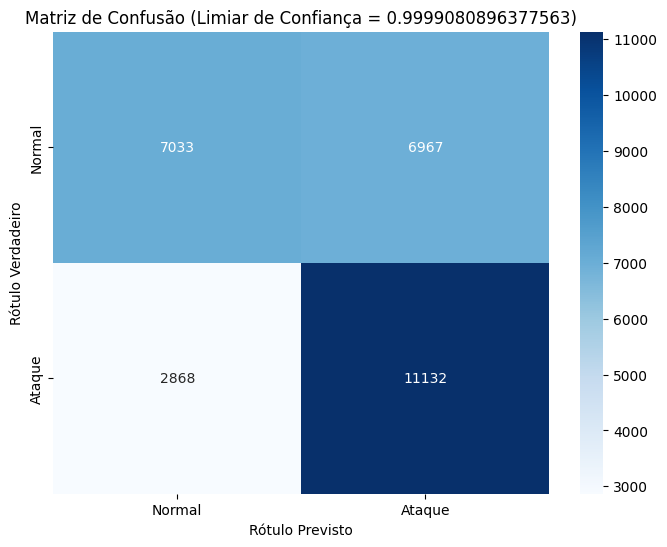

True Positives (TP): 11132
True Negatives (TN): 7033
False Positives (FP): 6967
False Negatives (FN): 2868

F1 Score: 0.6936
True Positive Rate (TPR) / Recall: 0.7951
True Negative Rate (TNR) / Specificity: 0.5024
--------------------
Threshold: 0.9999
  Accuracy: 0.6488
  Total Inference Time: 1.7532 s
  Early Exit Rate: 0.3725 (10430/28000)
--------------------


--- Model: CIC_EA | Loader: UNSW_EA | TestID: 1 ---
Model from: 'models/CIC_EA_1.pth' carregado


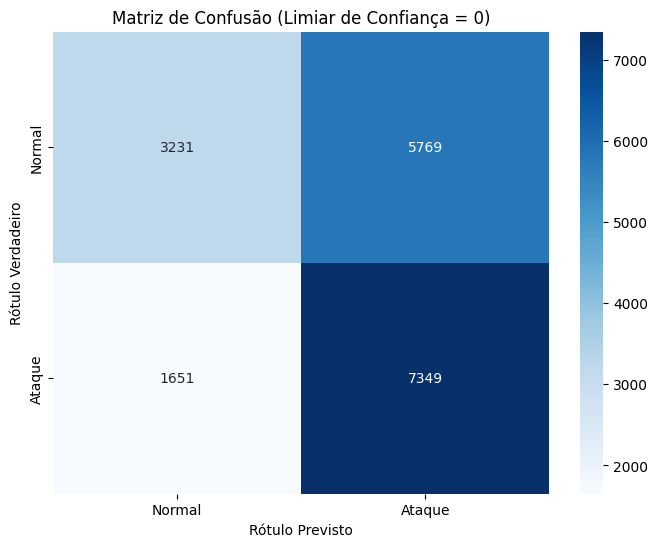

True Positives (TP): 7349
True Negatives (TN): 3231
False Positives (FP): 5769
False Negatives (FN): 1651

F1 Score: 0.6645
True Positive Rate (TPR) / Recall: 0.8166
True Negative Rate (TNR) / Specificity: 0.3590
--------------------
Threshold: 0.0000
  Accuracy: 0.5878
  Total Inference Time: 0.6838 s
  Early Exit Rate: 1.0000 (18000/18000)
--------------------


--- Model: CIC_EA | Loader: UNSW_EA | TestID: 2 ---
Model from: 'models/CIC_EA_2.pth' carregado


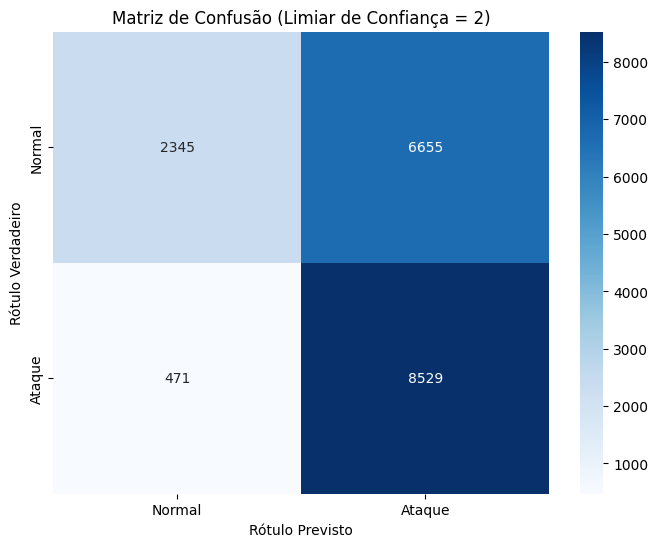

True Positives (TP): 8529
True Negatives (TN): 2345
False Positives (FP): 6655
False Negatives (FN): 471

F1 Score: 0.7053
True Positive Rate (TPR) / Recall: 0.9477
True Negative Rate (TNR) / Specificity: 0.2606
--------------------
Threshold: 2.0000
  Accuracy: 0.6041
  Total Inference Time: 0.9371 s
  Early Exit Rate: 0.0000 (0/18000)
--------------------


--- Model: CIC_EA | Loader: UNSW_EA | TestID: 3 ---
Model from: 'models/CIC_EA_3.pth' carregado


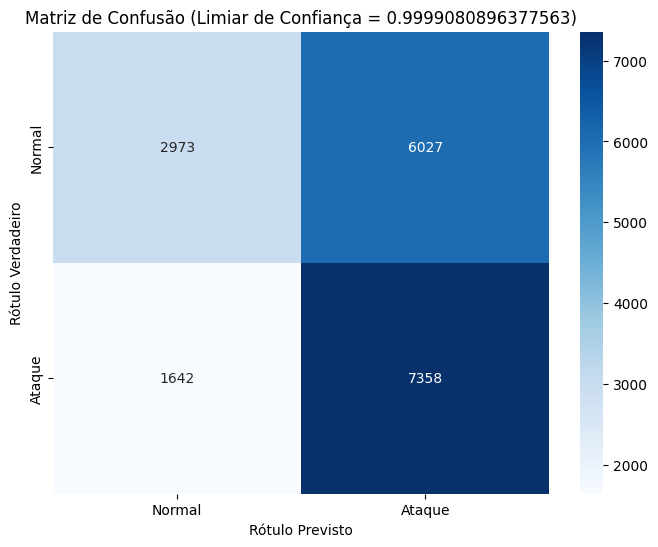

True Positives (TP): 7358
True Negatives (TN): 2973
False Positives (FP): 6027
False Negatives (FN): 1642

F1 Score: 0.6574
True Positive Rate (TPR) / Recall: 0.8176
True Negative Rate (TNR) / Specificity: 0.3303
--------------------
Threshold: 0.9999
  Accuracy: 0.5739
  Total Inference Time: 0.9619 s
  Early Exit Rate: 0.0023 (42/18000)
--------------------


--- Model: CIC_EA | Loader: BOT_EA | TestID: 1 ---
Model from: 'models/CIC_EA_1.pth' carregado


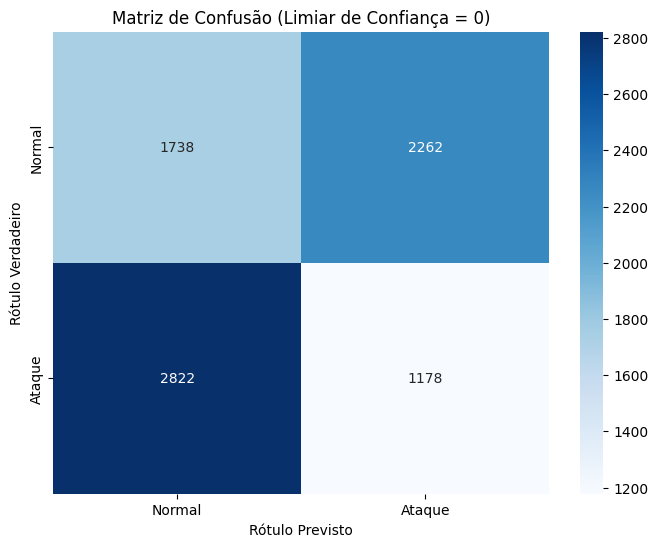

True Positives (TP): 1178
True Negatives (TN): 1738
False Positives (FP): 2262
False Negatives (FN): 2822

F1 Score: 0.3167
True Positive Rate (TPR) / Recall: 0.2945
True Negative Rate (TNR) / Specificity: 0.4345
--------------------
Threshold: 0.0000
  Accuracy: 0.3645
  Total Inference Time: 0.3082 s
  Early Exit Rate: 1.0000 (8000/8000)
--------------------


--- Model: CIC_EA | Loader: BOT_EA | TestID: 2 ---
Model from: 'models/CIC_EA_2.pth' carregado


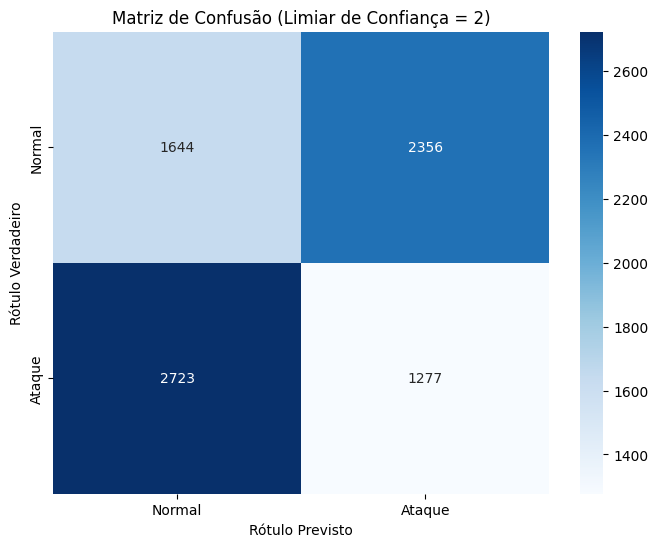

True Positives (TP): 1277
True Negatives (TN): 1644
False Positives (FP): 2356
False Negatives (FN): 2723

F1 Score: 0.3346
True Positive Rate (TPR) / Recall: 0.3192
True Negative Rate (TNR) / Specificity: 0.4110
--------------------
Threshold: 2.0000
  Accuracy: 0.3651
  Total Inference Time: 0.4508 s
  Early Exit Rate: 0.0000 (0/8000)
--------------------


--- Model: CIC_EA | Loader: BOT_EA | TestID: 3 ---
Model from: 'models/CIC_EA_3.pth' carregado


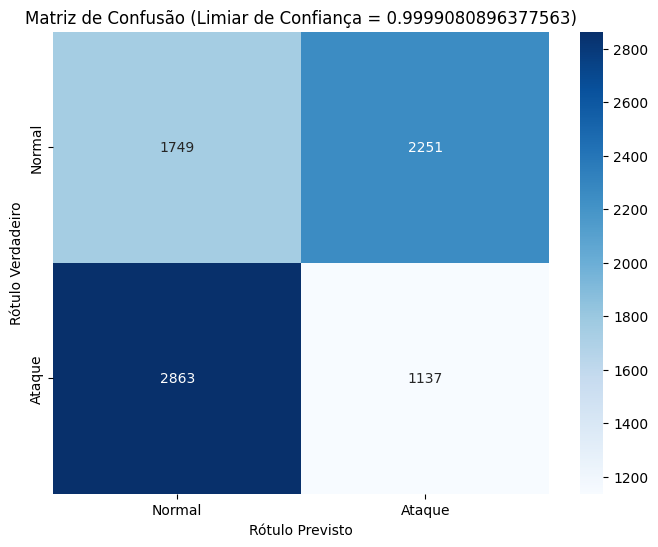

True Positives (TP): 1137
True Negatives (TN): 1749
False Positives (FP): 2251
False Negatives (FN): 2863

F1 Score: 0.3078
True Positive Rate (TPR) / Recall: 0.2843
True Negative Rate (TNR) / Specificity: 0.4373
--------------------
Threshold: 0.9999
  Accuracy: 0.3608
  Total Inference Time: 0.4763 s
  Early Exit Rate: 0.0076 (61/8000)
--------------------


--- Model: CIC_EA | Loader: CIC_EA | TestID: 1 ---
Model from: 'models/CIC_EA_1.pth' carregado


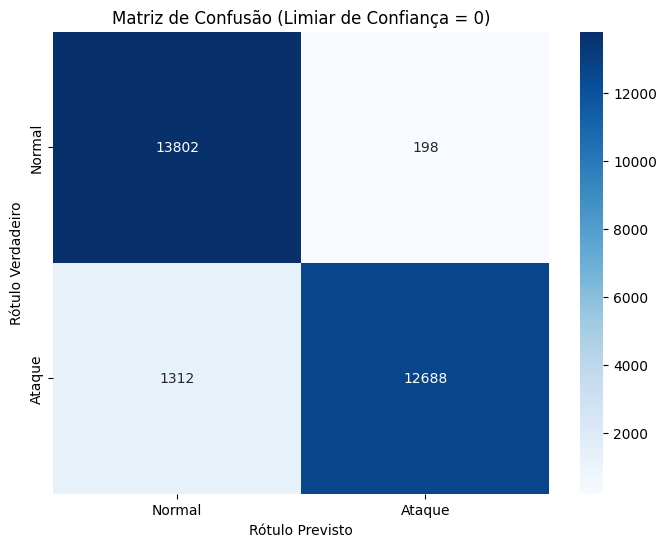

True Positives (TP): 12688
True Negatives (TN): 13802
False Positives (FP): 198
False Negatives (FN): 1312

F1 Score: 0.9438
True Positive Rate (TPR) / Recall: 0.9063
True Negative Rate (TNR) / Specificity: 0.9859
--------------------
Threshold: 0.0000
  Accuracy: 0.9461
  Total Inference Time: 1.0286 s
  Early Exit Rate: 1.0000 (28000/28000)
--------------------


--- Model: CIC_EA | Loader: CIC_EA | TestID: 2 ---
Model from: 'models/CIC_EA_2.pth' carregado


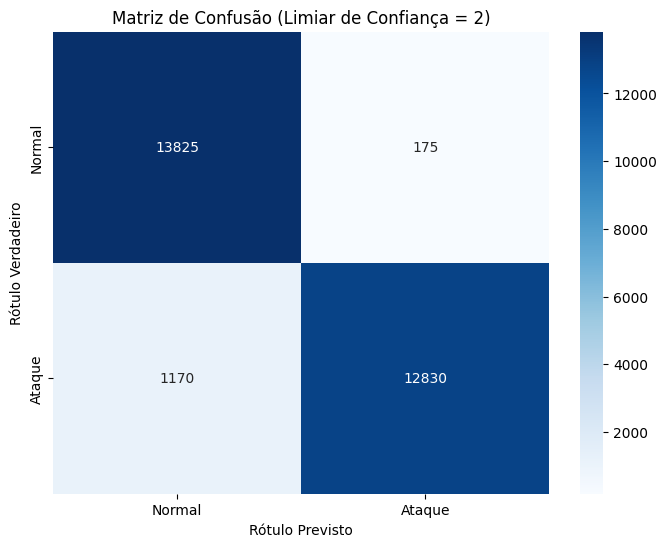

True Positives (TP): 12830
True Negatives (TN): 13825
False Positives (FP): 175
False Negatives (FN): 1170

F1 Score: 0.9502
True Positive Rate (TPR) / Recall: 0.9164
True Negative Rate (TNR) / Specificity: 0.9875
--------------------
Threshold: 2.0000
  Accuracy: 0.9520
  Total Inference Time: 1.4921 s
  Early Exit Rate: 0.0000 (0/28000)
--------------------


--- Model: CIC_EA | Loader: CIC_EA | TestID: 3 ---
Model from: 'models/CIC_EA_3.pth' carregado


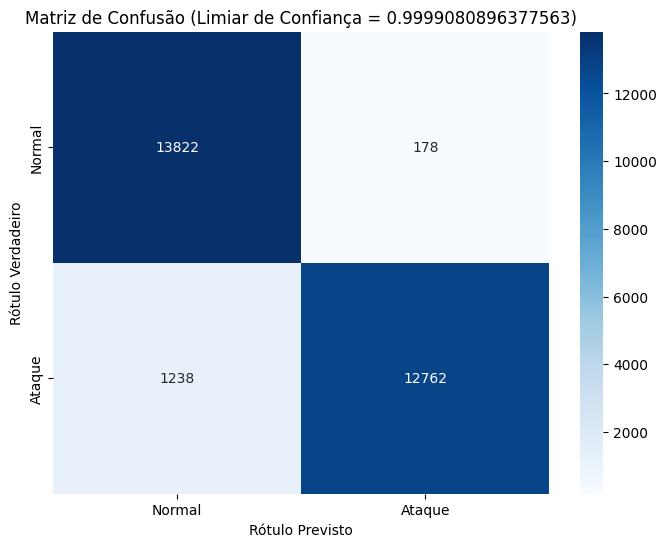

True Positives (TP): 12762
True Negatives (TN): 13822
False Positives (FP): 178
False Negatives (FN): 1238

F1 Score: 0.9474
True Positive Rate (TPR) / Recall: 0.9116
True Negative Rate (TNR) / Specificity: 0.9873
--------------------
Threshold: 0.9999
  Accuracy: 0.9494
  Total Inference Time: 1.7453 s
  Early Exit Rate: 0.1555 (4355/28000)
--------------------




In [12]:
target_exit_rate = 0.20
percentile_threshold = (1 - target_exit_rate) * 100 
global_confs = []

for model_id in range(len(model_names)):
    model = IDSBranchyNet() 
    model.load_state_dict(torch.load(f'models/{model_names[model_id]}_3.pth'))
    model.to(device)
    model.eval()
    
    for loader in range(len(test_loaders)):
        with torch.no_grad():
            for samples, _ in test_loaders[loader]:
                samples = samples.to(device)
                
                branch_output = model.forward_exit1(samples)
                branch_prob = F.softmax(branch_output, dim=1)
                branch_conf, _ = torch.max(branch_prob, 1)
                
                global_confs.append(branch_conf.cpu().numpy())

global_confs = np.concatenate(global_confs)
fixed_threshold_t3 = np.percentile(global_confs, percentile_threshold)

print(f"{fixed_threshold_t3:.4f}")

for model_id in range(len(model_names)):
    for loader in range(len(test_loaders)):
        for test in test_ids:
    
            print(f"--- Model: {model_names[model_id]} | Loader: {model_names[loader]} | TestID: {test} ---")
    
            model.load_state_dict(torch.load(f'models/{model_names[model_id]}_{test}.pth'))
            model.to(device)
            model.eval()
            print(f"Model from: 'models/{model_names[model_id]}_{test}.pth' carregado")

            if test == 1:
                t=0
            elif test == 2:
                t=2
            elif test == 3:
                t=fixed_threshold_t3
    
            results = evaluate_model(model, test_loaders[loader], confidence_threshold=t, device=device)
            
            print("-" * 20)
            print(f"Threshold: {t:.4f}")
            print(f"  Accuracy: {results['accuracy']:.4f}")
            print(f"  Total Inference Time: {results['total_inference_time_sec']:.4f} s")
            print(f"  Early Exit Rate: {results['exit_rate']:.4f} ({results['exited_early_count']}/{results['total_samples']})")
            print("-" * 20)
            print("\n")